In [2]:
ENV["LINES"], ENV["COLUMNS"] = 100, 100
using Base.Threads
using BenchmarkTools
using DataFrames
using Distributions
using LinearAlgebra
using Memoization
using Printf
using QuadGK
#using RCall
using Random
Random.seed!(4649373)
using Roots
using SpecialFunctions
using StaticArrays
using StatsBase
using StatsFuns
using StatsPlots
default(fmt = :png, size = (400, 250),
    titlefontsize = 10, plot_titlefontsize = 12)
using SymPy

In [8]:
# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105

@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " *
            sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " *
                sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&")
                for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

In [9]:
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

x ⪅ y = x < y || x ≈ y

mypdf(dist, x) = pdf(dist, x)
mypdf(dist::DiscreteUnivariateDistribution, x) = pdf(dist, round(Int, x))

distname(dist::Distribution) = replace(string(dist), r"{.*}" => "")
myskewness(dist) = skewness(dist)
mykurtosis(dist) = kurtosis(dist)
function standardized_moment(dist::ContinuousUnivariateDistribution, m)
    μ, σ = mean(dist), std(dist)
    quadgk(x -> (x - μ)^m * pdf(dist, x), extrema(dist)...)[1] / σ^m
end
myskewness(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 3)
mykurtosis(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 4) - 3

mykurtosis (generic function with 2 methods)

In [10]:
oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_or_wald (generic function with 1 method)

In [11]:
@show confint_or_wald(0, 1, 1, 1) confint_or_wald(1e-4, 1, 1, 1)
@show confint_or_wald(1, 0, 1, 1) confint_or_wald(1, 1e-4, 1, 1)
@show confint_or_wald(1, 1, 0, 1) confint_or_wald(1, 1, 1e-4, 1)
@show confint_or_wald(1, 1, 1, 0) confint_or_wald(1, 1, 1, 1e-4)
@show confint_or_wald(0, 0, 1, 1) confint_or_wald(1e-4, 1e-4, 1, 1)
@show confint_or_wald(1, 1, 0, 0) confint_or_wald(1, 1, 1e-4, 1e-4)
@show confint_or_wald(0, 1, 0, 1) confint_or_wald(1e-4, 1, 1e-4, 1)
@show confint_or_wald(1, 0, 1, 0) confint_or_wald(1, 1e-4, 1, 1e-4);

confint_or_wald(0, 1, 1, 1) = [0.0, Inf]
confint_or_wald(0.0001, 1, 1, 1) = [7.363403724036157e-90, 1.3580675968312418e81]
confint_or_wald(1, 0, 1, 1) = [0.0, Inf]
confint_or_wald(1, 0.0001, 1, 1) = [7.363403724036156e-82, 1.3580675968312418e89]
confint_or_wald(1, 1, 0, 1) = [0.0, Inf]
confint_or_wald(1, 1, 0.0001, 1) = [7.363403724036156e-82, 1.3580675968312418e89]
confint_or_wald(1, 1, 1, 0) = [0.0, Inf]
confint_or_wald(1, 1, 1, 0.0001) = [7.363403724036157e-90, 1.3580675968312418e81]
confint_or_wald(0, 0, 1, 1) = [0.0, Inf]
confint_or_wald(0.0001, 0.0001, 1, 1) = [4.1295675438516624e-121, 2.4215610699693177e120]
confint_or_wald(1, 1, 0, 0) = [0.0, Inf]
confint_or_wald(1, 1, 0.0001, 0.0001) = [4.1295675438516624e-121, 2.4215610699693177e120]
confint_or_wald(0, 1, 0, 1) = [0.0, Inf]
confint_or_wald(0.0001, 1, 0.0001, 1) = [4.1295675438516624e-121, 2.4215610699693177e120]
confint_or_wald(1, 0, 1, 0) = [0.0, Inf]
confint_or_wald(1, 0.0001, 1, 0.0001) = [4.1295675438516624e-121, 2.421561

In [12]:
riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

confint_rr_wald (generic function with 1 method)

In [13]:
@show confint_rr_wald(0, 1, 1, 1) confint_rr_wald(1e-4, 1, 1, 1)
@show confint_rr_wald(1, 0, 1, 1) confint_rr_wald(1, 1e-4, 1, 1)
@show confint_rr_wald(1, 1, 0, 1) confint_rr_wald(1, 1, 1e-4, 1)
@show confint_rr_wald(1, 1, 1, 0) confint_rr_wald(1, 1, 1, 1e-4)
@show confint_rr_wald(0, 0, 1, 1) confint_rr_wald(1e-4, 1e-4, 1, 1)
@show confint_rr_wald(1, 1, 0, 0) confint_rr_wald(1, 1, 1e-4, 1e-4)
@show confint_rr_wald(0, 1, 0, 1) confint_rr_wald(1e-4, 1, 1e-4, 1)
@show confint_rr_wald(1, 0, 1, 0) confint_rr_wald(1, 1e-4, 1, 1e-4);

confint_rr_wald(0, 1, 1, 1) = [0.0, Inf]
confint_rr_wald(0.0001, 1, 1, 1) = [1.5239118697601845e-89, 2.62429881894243e81]
confint_rr_wald(1, 0, 1, 1) = [0.5001953065198115, 7.996876315834783]
confint_rr_wald(1, 0.0001, 1, 1) = [0.5000759918604454, 7.997184798065742]
confint_rr_wald(1, 1, 0, 1) = [0.0, Inf]
confint_rr_wald(1, 1, 0.0001, 1) = [3.810541668433138e-82, 6.562059262373016e88]
confint_rr_wald(1, 1, 1, 0) = [0.12504882662995287, 1.9992190789586957]
confint_rr_wald(1, 1, 1, 0.0001) = [0.12504400301489435, 1.999696078749301]
confint_rr_wald(0, 0, 1, 1) = [0.0, Inf]
confint_rr_wald(0.0001, 0.0001, 1, 1) = [6.426171133615772e-61, 1.5561365846124554e60]
confint_rr_wald(1, 1, 0, 0) = [0.0, Inf]
confint_rr_wald(1, 1, 0.0001, 0.0001) = [6.426171133615772e-61, 1.5561365846124554e60]
confint_rr_wald(0, 1, 0, 1) = [0.0, Inf]
confint_rr_wald(0.0001, 1, 0.0001, 1) = [4.245626444711269e-121, 2.3553650162644178e120]
confint_rr_wald(1, 0, 1, 0) = [1.0, 1.0]
confint_rr_wald(1, 0.0001, 1, 0.0001

In [14]:
# 警告: 以下の実装の精度は低い. 改良の仕方が
# 
# Kenneth J. Rothman, Sander Greenland, and Timothy L. Lash
# Modern Epistemology, Third Edition, 2008, 888 pages
#
# の
#
# Chapter 14. Instroduction to Categorical Statistics
# Section. Two Study Groups: Large-Sample Methods, pp.299-300
#
# に書いてある. そこでは, 次の文献が引用されている:
#
# Guangyong Zou and Allan Donner
# A simple alternative confidence interval for the difference between two proportions
# Controlled Clinical Trials, Volume 25, Issue 1, February 2004, Pages 3-12
# https://doi.org/10.1016/j.cct.2003.08.010
#
# Zou-Donnerの信頼区間に対応するP値函数の実装については
#
# https://github.com/genkuroki/public/blob/main/0033/probability%20of%20alpha%20error%20of%20Zou-Donner.ipynb
#
# を参照せよ.

riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m) + safediv(q̂*(1-q̂), n))
end

function pvalue_rd_wald(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

confint_rd_wald (generic function with 1 method)

In [15]:
@show confint_rd_wald(0, 1, 1, 1) confint_rd_wald(1e-4, 1, 1, 1)
@show confint_rd_wald(1, 0, 1, 1) confint_rd_wald(1, 1e-4, 1, 1)
@show confint_rd_wald(1, 1, 0, 1) confint_rd_wald(1, 1, 1e-4, 1)
@show confint_rd_wald(1, 1, 1, 0) confint_rd_wald(1, 1, 1, 1e-4)
@show confint_rd_wald(0, 0, 1, 1) confint_rd_wald(1e-4, 1e-8, 1, 1)
@show confint_rd_wald(1, 1, 0, 0) confint_rd_wald(1, 1, 1e-4, 1e-8)
@show confint_rd_wald(0, 1, 0, 1) confint_rd_wald(1e-4, 1, 1e-8, 1)
@show confint_rd_wald(1, 0, 1, 0) confint_rd_wald(1, 1e-4, 1, 1e-8);

confint_rd_wald(0, 1, 1, 1) = [-1.1929519121748402, 0.1929519121748402]
confint_rd_wald(0.0001, 1, 1, 1) = [-1.1931289644203495, 0.19332894442234927]
confint_rd_wald(1, 0, 1, 1) = [-0.1929519121748402, 1.1929519121748402]
confint_rd_wald(1, 0.0001, 1, 1) = [-0.19332894442234927, 1.1931289644203495]
confint_rd_wald(1, 1, 0, 1) = [-0.1929519121748402, 1.1929519121748402]
confint_rd_wald(1, 1, 0.0001, 1) = [-0.19332894442234927, 1.1931289644203495]
confint_rd_wald(1, 1, 1, 0) = [-1.1929519121748402, 0.1929519121748402]
confint_rd_wald(1, 1, 1, 0.0001) = [-1.1931289644203495, 0.19332894442234927]
confint_rd_wald(0, 0, 1, 1) = [-1.1929519121748402, 0.1929519121748402]
confint_rd_wald(0.0001, 1.0e-8, 1, 1) = [-1.5786785827129024, 2.5784786027109026]
confint_rd_wald(1, 1, 0, 0) = [-0.1929519121748402, 1.1929519121748402]
confint_rd_wald(1, 1, 0.0001, 1.0e-8) = [-2.5784786027109026, 1.5786785827129024]
confint_rd_wald(0, 1, 0, 1) = [0.0, 0.0]
confint_rd_wald(0.0001, 1, 1.0e-8, 1) = [-0.0194977

In [16]:
function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [17]:
@show confint_or_pearson_chisq(0, 1, 1, 1) confint_or_pearson_chisq(1e-4, 1, 1, 1)
@show confint_or_pearson_chisq(1, 0, 1, 1) confint_or_pearson_chisq(1, 1e-4, 1, 1)
@show confint_or_pearson_chisq(1, 1, 0, 1) confint_or_pearson_chisq(1, 1, 1e-4, 1)
@show confint_or_pearson_chisq(1, 1, 1, 0) confint_or_pearson_chisq(1, 1, 1, 1e-4)
@show confint_or_pearson_chisq(0, 0, 1, 1) confint_or_pearson_chisq(1e-4, 1e-4, 1, 1)
@show confint_or_pearson_chisq(1, 1, 0, 0) confint_or_pearson_chisq(1, 1, 1e-4, 1e-4)
@show confint_or_pearson_chisq(0, 1, 0, 1) confint_or_pearson_chisq(1e-4, 1, 1e-4, 1)
@show confint_or_pearson_chisq(1, 0, 1, 0) confint_or_pearson_chisq(1, 1e-4, 1, 1e-4);

confint_or_pearson_chisq(0, 1, 1, 1) = [0.0, 11.137973937616904]
confint_or_pearson_chisq(0.0001, 1, 1, 1) = [2.602261452525905e-9, 11.140095739591606]
confint_or_pearson_chisq(1, 0, 1, 1) = [0.08978293589129746, Inf]
confint_or_pearson_chisq(1, 0.0001, 1, 1) = [0.08976583535507918, 3.842811409403394e8]
confint_or_pearson_chisq(1, 1, 0, 1) = [0.08978293589129746, Inf]
confint_or_pearson_chisq(1, 1, 0.0001, 1) = [0.08976583535507918, 3.842811409403394e8]
confint_or_pearson_chisq(1, 1, 1, 0) = [0.0, 11.137973937616904]
confint_or_pearson_chisq(1, 1, 1, 0.0001) = [2.602261452525905e-9, 11.140095739591601]
confint_or_pearson_chisq(0, 0, 1, 1) = [0.0, Inf]
confint_or_pearson_chisq(0.0001, 0.0001, 1, 1) = [1.3012947051505169e-5, 76846.54337277808]
confint_or_pearson_chisq(1, 1, 0, 0) = [0.0, Inf]
confint_or_pearson_chisq(1, 1, 0.0001, 0.0001) = [1.3012947051505169e-5, 76846.54337277808]
confint_or_pearson_chisq(0, 1, 0, 1) = [0.0, Inf]
confint_or_pearson_chisq(0.0001, 1, 0.0001, 1) = [1.3012

In [18]:
# Cornfeild (1956), p.139, (4.2) と比較せよ.
a, b, c, d = 3, 11, 60, 32
@show confint_or_wald(a, b, c, d)
@show confint_or_pearson_chisq(a, b, c, d)
@show confint_or_pearson_chisq(a, b, c, d; correction=0.5);

confint_or_wald(a, b, c, d) = [0.037829803607039435, 0.5592686923030045]
confint_or_pearson_chisq(a, b, c, d) = [0.04084291410483445, 0.5253472140108638]
confint_or_pearson_chisq(a, b, c, d; correction = 0.5) = [0.02962955731952911, 0.6228119542455192]


In [19]:
function Delta(a, b, c, d; ρ=1)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    isinf(ρ) ? typeof(ω)(-c) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    RRhat = riskratiohat(a, b, c, d)
    if a == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif c == 0
        [exp(find_zero(f, 0.0)), Inf]
    elseif b == 0
        [0.0, exp(find_zero(f, log(2RRhat)))]
    elseif d == 0
        [exp(find_zero(f, log(RRhat/2))), Inf]
    else
        ρ_L, ρ_U = RRhat/2, 2RRhat
        [exp(find_zero(f, log(ρ_L))), exp(find_zero(f, log(ρ_U)))]
    end
end

confint_rr_pearson_chisq (generic function with 1 method)

In [20]:
@show confint_rr_pearson_chisq(0, 1, 1, 1) confint_rr_pearson_chisq(1e-4, 1, 1, 1)
@show confint_rr_pearson_chisq(1, 0, 1, 1) confint_rr_pearson_chisq(1, 1e-4, 1, 1)
@show confint_rr_pearson_chisq(1, 1, 0, 1) confint_rr_pearson_chisq(1, 1, 1e-4, 1)
@show confint_rr_pearson_chisq(1, 1, 1, 0) confint_rr_pearson_chisq(1, 1, 1, 1e-4)
@show confint_rr_pearson_chisq(0, 0, 1, 1) confint_rr_pearson_chisq(1e-4, 1e-4, 1, 1)
@show confint_rr_pearson_chisq(1, 1, 0, 0) confint_rr_pearson_chisq(1, 1, 1e-4, 1e-4)
@show confint_rr_pearson_chisq(0, 1, 0, 1) confint_rr_pearson_chisq(1e-4, 1, 1e-4, 1)
@show confint_rr_pearson_chisq(1, 0, 1, 0) confint_rr_pearson_chisq(1, 1e-4, 1, 1e-4);

confint_rr_pearson_chisq(0, 1, 1, 1) = [0.0, 4.10417860525958]
confint_rr_pearson_chisq(0.0001, 1, 1, 1) = [5.205303607358693e-9, 4.104616767401084]
confint_rr_pearson_chisq(1, 0, 1, 1) = [0.0, 10.578517350254106]
confint_rr_pearson_chisq(1, 0.0001, 1, 1) = [0.32665454735880284, 10.577873776111911]
confint_rr_pearson_chisq(1, 1, 0, 1) = [0.2436541135706135, Inf]
confint_rr_pearson_chisq(1, 1, 0.0001, 1) = [0.24362810383225364, 1.9211175282574818e8]
confint_rr_pearson_chisq(1, 1, 1, 0) = [0.09453120573423061, Inf]
confint_rr_pearson_chisq(1, 1, 1, 0.0001) = [0.0945369571584704, 3.0613380652042177]
confint_rr_pearson_chisq(0, 0, 1, 1) = [0.0, Inf]
confint_rr_pearson_chisq(0.0001, 0.0001, 1, 1) = [2.602945936963888e-5, 9.681923544184194]
confint_rr_pearson_chisq(1, 1, 0, 0) = [0.0, Inf]
confint_rr_pearson_chisq(1, 1, 0.0001, 0.0001) = [0.10328526097487344, 38418.00883361873]
confint_rr_pearson_chisq(0, 1, 0, 1) = [0.0, Inf]
confint_rr_pearson_chisq(0.0001, 1, 0.0001, 1) = [1.3016851156610

In [21]:
_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_or_sterne(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_sterne(fnch, a)
end

function confint_or_sterne(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_sterne(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        [first(ps), last(ps)]
    end
end

confint_or_sterne (generic function with 1 method)

In [22]:
@show confint_or_sterne(0, 10, 10, 10) confint_or_pearson_chisq(1e-4, 10, 10, 10)
@show confint_or_sterne(10, 0, 10, 10) confint_or_pearson_chisq(10, 1e-4, 10, 10)
@show confint_or_sterne(10, 10, 0, 10) confint_or_pearson_chisq(10, 10, 1e-4, 10)
@show confint_or_sterne(10, 10, 10, 0) confint_or_pearson_chisq(10, 10, 10, 1e-4)
@show confint_or_sterne(0, 0, 10, 10) confint_or_pearson_chisq(1e-4, 1e-4, 10, 10)
@show confint_or_sterne(10, 10, 0, 0) confint_or_pearson_chisq(10, 10, 1e-4, 1e-4)
@show confint_or_sterne(0, 10, 0, 10) confint_or_pearson_chisq(1e-4, 10, 1e-4, 10)
@show confint_or_sterne(10, 0, 10, 0) confint_or_pearson_chisq(10, 1e-4, 10, 1e-4);

confint_or_sterne(0, 10, 10, 10) = [0.0, 0.5431888559914949]
confint_or_pearson_chisq(0.0001, 10, 10, 10) = [2.6029641085026625e-10, 0.44168708894449726]
confint_or_sterne(10, 0, 10, 10) = [1.8409803311864292, Inf]
confint_or_pearson_chisq(10, 0.0001, 10, 10) = [2.264046255890583, 3.8417740633827114e9]
confint_or_sterne(10, 10, 0, 10) = [1.8409803311864295, Inf]
confint_or_pearson_chisq(10, 10, 0.0001, 10) = [2.264046255890583, 3.841774063392443e9]
confint_or_sterne(10, 10, 10, 0) = [0.0, 0.5431888559914949]
confint_or_pearson_chisq(10, 10, 10, 0.0001) = [2.6029641085026625e-10, 0.44168708894449726]
confint_or_sterne(0, 0, 10, 10) = [0.0, Inf]
confint_or_pearson_chisq(0.0001, 0.0001, 10, 10) = [1.301528947084912e-5, 76832.712959483]
confint_or_sterne(10, 10, 0, 0) = [0.0, Inf]
confint_or_pearson_chisq(10, 10, 0.0001, 0.0001) = [1.301528947084912e-5, 76832.7129594542]
confint_or_sterne(0, 10, 0, 10) = [0.0, Inf]
confint_or_pearson_chisq(0.0001, 10, 0.0001, 10) = [1.301528947084912e-5, 7

In [24]:
function pvalue_or_clopper_pearson(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    min(1, 2cdf(fnch, a), 2ccdf(fnch, a-1))
end

function confint_or_clopper_pearson(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(ω) = logit(pvalue_or_clopper_pearson(a, b, c, d; ω)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        find_zeros(f, ω_L, ω_U)
    end
end

confint_or_clopper_pearson (generic function with 1 method)

In [25]:
@show confint_or_clopper_pearson(0, 10, 10, 10) confint_or_sterne(0, 10, 10, 10)
@show confint_or_clopper_pearson(10, 0, 10, 10) confint_or_sterne(10, 0, 10, 10)
@show confint_or_clopper_pearson(10, 10, 0, 10) confint_or_sterne(10, 10, 0, 10)
@show confint_or_clopper_pearson(10, 10, 10, 0) confint_or_sterne(10, 10, 10, 0)
@show confint_or_clopper_pearson(0, 0, 10, 10) confint_or_sterne(0, 0, 10, 10)
@show confint_or_clopper_pearson(10, 10, 0, 0) confint_or_sterne(10, 10, 0, 0)
@show confint_or_clopper_pearson(0, 10, 0, 10) confint_or_sterne(0, 10, 0, 10)
@show confint_or_clopper_pearson(10, 0, 10, 0) confint_or_sterne(10, 0, 10, 0);

confint_or_clopper_pearson(0, 10, 10, 10) = [0.0, 0.6246724957742202]
confint_or_sterne(0, 10, 10, 10) = [0.0, 0.5431888559914949]
confint_or_clopper_pearson(10, 0, 10, 10) = [1.6008388503812658, Inf]
confint_or_sterne(10, 0, 10, 10) = [1.8409803311864292, Inf]
confint_or_clopper_pearson(10, 10, 0, 10) = [1.600838850381266, Inf]
confint_or_sterne(10, 10, 0, 10) = [1.8409803311864295, Inf]
confint_or_clopper_pearson(10, 10, 10, 0) = [0.0, 0.6246724957742202]
confint_or_sterne(10, 10, 10, 0) = [0.0, 0.5431888559914949]
confint_or_clopper_pearson(0, 0, 10, 10) = [0.0, Inf]
confint_or_sterne(0, 0, 10, 10) = [0.0, Inf]
confint_or_clopper_pearson(10, 10, 0, 0) = [0.0, Inf]
confint_or_sterne(10, 10, 0, 0) = [0.0, Inf]
confint_or_clopper_pearson(0, 10, 0, 10) = [0.0, Inf]
confint_or_sterne(0, 10, 0, 10) = [0.0, Inf]
confint_or_clopper_pearson(10, 0, 10, 0) = [0.0, Inf]
confint_or_sterne(10, 0, 10, 0) = [0.0, Inf]


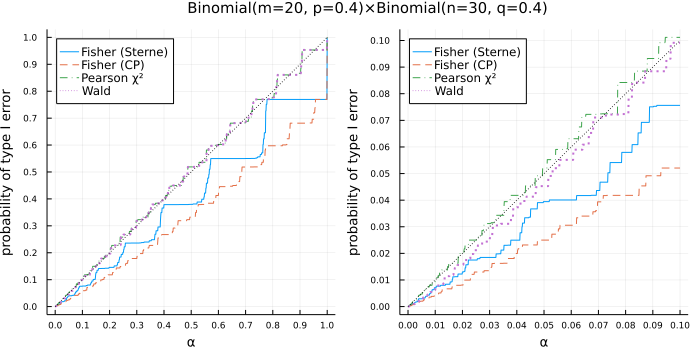

In [26]:
function sim_probabilities_of_type_I_error(m, n, p, q=p;
    ω=p*(1-q)/((1-p)*q), L=10^5)
bina, binc = Binomial(m, p), Binomial(n, q)
p_sterne = similar(zeros(), L)
p_clopper_pearson = similar(zeros(), L)
p_pearson_chisq = similar(zeros(), L)
p_wald = similar(zeros(), L)
@threads for i in 1:L
    a, c = rand(bina), rand(binc)
    b, d = m-a, n-c
    p_sterne[i] = pvalue_or_sterne(a, b, c, d; ω)
    p_clopper_pearson[i] = pvalue_or_clopper_pearson(a, b, c, d; ω)
    p_pearson_chisq[i] = pvalue_or_pearson_chisq(a, b, c, d; ω)
    p_wald[i] = pvalue_or_wald(a, b, c, d; ω)
end
(; p_sterne, p_clopper_pearson, p_pearson_chisq, p_wald)
end

function plot_probabilities_of_type_I_error(m, n, p, q=p;
    ω=p*(1-q)/((1-p)*q), L=10^6, kwargs...)
(; p_sterne, p_clopper_pearson, p_pearson_chisq, p_wald) =
    sim_probabilities_of_type_I_error(m, n, p, q; ω, L)
F_sterne = ecdf(p_sterne)
F_clopper_pearson = ecdf(p_clopper_pearson)
F_pearson_chisq = ecdf(p_pearson_chisq)
F_wald = ecdf(p_wald)

x = 0:0.001:1
tick = 0:0.1:1
P = plot(; legend=:topleft)
plot!(x, x -> F_sterne(x); label="Fisher (Sterne)")
plot!(x, x -> F_clopper_pearson(x); label="Fisher (CP)", ls=:dash)
plot!(x, x -> F_pearson_chisq(x); label="Pearson χ²", ls=:dashdot)
plot!(x, x -> F_wald(x); label="Wald", ls=:dot, lw=2)
plot!(x, identity; label="", c=:black, ls=:dot)
plot!(; xtick=tick, ytick=tick, tickfontsize=6)
plot!(; xguide="α", yguide="probability of type I error",
    guidefontsize=9)

x = 0:0.0001:0.1
tick = 0:0.01:1
Q = plot(; legend=:topleft)
plot!(x, x -> F_sterne(x); label="Fisher (Sterne)")
plot!(x, x -> F_clopper_pearson(x); label="Fisher (CP)", ls=:dash)
plot!(x, x -> F_pearson_chisq(x); label="Pearson χ²", ls=:dashdot)
plot!(x, x -> F_wald(x); label="Wald", ls=:dot, lw=2)
plot!(x, identity; label="", c=:black, ls=:dot)
plot!(; xtick=tick, ytick=tick, tickfontsize=6)
plot!(; xguide="α", yguide="probability of type I error",
    guidefontsize=9)

plot(P, Q; size=(700, 350), layout=(1, 2))
plot!(; plot_title="Binomial(m=$m, p=$p)×Binomial(n=$n, q=$q)",
    plot_titlefontsize=10)
plot!(; kwargs...)
end

plot_probabilities_of_type_I_error(20, 30, 0.4)

In [31]:
a, b, c, d = 14, 5, 5, 9
@show a, b, c, d
ω = 1.0
@show ω
@show ORhat = a*d/(b*c)
@show SEhat = √(1/a + 1/b + 1/c + 1/d)
@show pvalue = 2ccdf(Normal(), abs(log(ORhat) - log(ω))/SEhat)
α = 0.05
@show α
@show z = quantile(Normal(), 1-α/2)
@show confint = [exp(-z*SEhat)*ORhat, exp(z*SEhat)*ORhat];

(a, b, c, d) = (14, 5, 5, 9)
ω = 1.0
ORhat = (a * d) / (b * c) = 5.04
SEhat = √(1 / a + 1 / b + 1 / c + 1 / d) = 0.7632428725770602
pvalue = 2 * ccdf(Normal(), abs(log(ORhat) - log(ω)) / SEhat) = 0.03408001186205061
α = 0.05
z = quantile(Normal(), 1 - α / 2) = 1.9599639845400576
confint = [exp(-z * SEhat) * ORhat, exp(z * SEhat) * ORhat] = [1.129164005040631, 22.495934945327953]


In [30]:
a, b, c, d = 14, 5, 5, 9
@show a, b, c, d
@show pvalue_or_wald(a, b, c, d; ω=1)
@show confint_or_wald(a, b, c, d; α=0.05);

(a, b, c, d) = (14, 5, 5, 9)
pvalue_or_wald(a, b, c, d; ω = 1) = 0.03408001186205061
confint_or_wald(a, b, c, d; α = 0.05) = [1.129164005040631, 22.495934945327953]


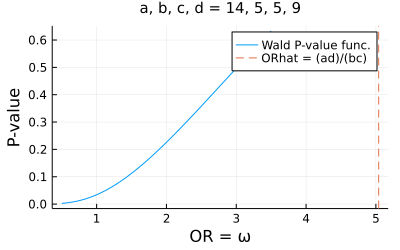

In [33]:
a, b, c, d = 14, 5, 5, 9
plot(ω -> pvalue_or_wald(a,b,c,d; ω), 0.5, 3.5; label="Wald P-value func.")
vline!([oddsratiohat(a,b,c,d)]; label="ORhat = (ad)/(bc)", ls=:dash)
plot!(; xguide="OR = ω", yguide="P-value")
plot!(; ytick=0:0.1:1)
title!("a, b, c, d = $a, $b, $c, $d")

In [40]:
a, b, c, d = 14, 5, 5, 9
@show a, b, c, d
χ² = (a+b+c+d)*(a*d-b*c)^2/((a+b)*(c+d)*(a+c)*(b+d))
@show χ²
@show pvalue = ccdf(Chisq(1), χ²)
α = 0.05
@show α
confint = find_zeros(0.5, 3.0) do ω
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    δ = 2C/(B + √(B^2 - 4A*C))
    χ² = δ^2 * (1/(a-δ) + 1/(b+δ) + 1/(c+δ) + 1/(d-δ))
    ccdf(Chisq(1), χ²) - α
end
@show confint;

(a, b, c, d) = (14, 5, 5, 9)
χ² = 4.757660127763017
pvalue = ccdf(Chisq(1), χ²) = 0.02916817454593672
α = 0.05
confint = [1.1690358178724083]


In [38]:
a, b, c, d = 14, 5, 5, 9
@show a, b, c, d
@show chisqstat_or(a, b, c, d; ω=1)
@show pvalue_or_pearson_chisq(a, b, c, d; ω=1)
@show confint_or_pearson_chisq(a, b, c, d; α=0.05);

(a, b, c, d) = (14, 5, 5, 9)
chisqstat_or(a, b, c, d; ω = 1) = 4.757660127763016
pvalue_or_pearson_chisq(a, b, c, d; ω = 1) = 0.029168174545936745
confint_or_pearson_chisq(a, b, c, d; α = 0.05) = [1.169035817872408, 21.75957805549801]


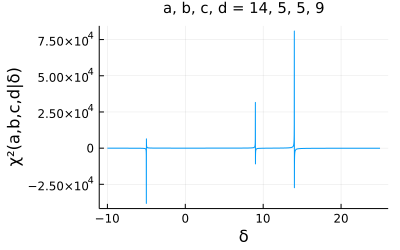

In [43]:
a, b, c, d = 14, 5, 5, 9
plot(δ -> _chisqstat_or(a,b,c,d,δ), -10, 25; label="")
plot!(; xguide="δ", yguide="χ²(a,b,c,d|δ)")
title!("a, b, c, d = $a, $b, $c, $d")

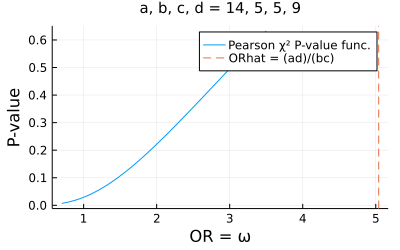

In [44]:
a, b, c, d = 14, 5, 5, 9
plot(ω -> pvalue_or_pearson_chisq(a,b,c,d;ω), 0.7, 3.5; label="Pearson χ² P-value func.")
vline!([oddsratiohat(a,b,c,d)]; label="ORhat = (ad)/(bc)", ls=:dash)
plot!(; xguide="OR = ω", yguide="P-value")
plot!(; ytick=0:0.1:1)
title!("a, b, c, d = $a, $b, $c, $d")

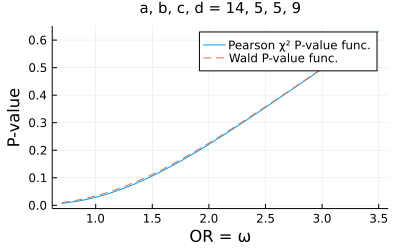

In [45]:
a, b, c, d = 14, 5, 5, 9
plot(ω -> pvalue_or_pearson_chisq(a,b,c,d; ω), 0.7, 3.5;
    label="Pearson χ² P-value func.")
plot!(ω -> pvalue_or_wald(a,b,c,d; ω), 0.7, 3.5;
    label="Wald P-value func.", ls=:dash)
plot!(; xguide="OR = ω", yguide="P-value")
plot!(; ytick=0:0.1:1)
title!("a, b, c, d = $a, $b, $c, $d")

In [46]:
a, b, c, d = 14, 5, 5, 9
@show oddsratiohat(a, b, c, d)
@show pvalue_or_wald(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d)
@show pvalue_or_sterne(a, b, c, d)
@show pvalue_or_clopper_pearson(a, b, c, d)
@show confint_or_wald(a, b, c, d)
@show confint_or_pearson_chisq(a, b, c, d)
@show confint_or_sterne(a, b, c, d)
@show confint_or_clopper_pearson(a, b, c, d);

oddsratiohat(a, b, c, d) = 5.04
pvalue_or_wald(a, b, c, d) = 0.03408001186205061
pvalue_or_pearson_chisq(a, b, c, d) = 0.029168174545936745
pvalue_or_sterne(a, b, c, d) = 0.039697233494689524
pvalue_or_clopper_pearson(a, b, c, d) = 0.06723831632570795
confint_or_wald(a, b, c, d) = [1.129164005040631, 22.495934945327953]
confint_or_pearson_chisq(a, b, c, d) = [1.169035817872408, 21.75957805549801]
confint_or_sterne(a, b, c, d) = [1.0282335654387784, 25.94775042488098]
confint_or_clopper_pearson(a, b, c, d) = [0.9144515866447722, 29.290145781864734]


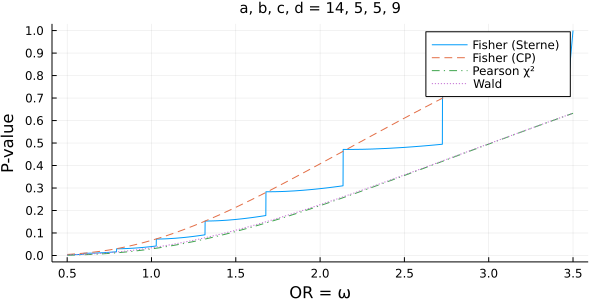

In [47]:
a, b, c, d = 14, 5, 5, 9
plot(ω -> pvalue_or_sterne(a,b,c,d; ω), 0.5, 3.5; label="Fisher (Sterne)")
plot!(ω -> pvalue_or_clopper_pearson(a,b,c,d; ω), 0.5, 3.5; label="Fisher (CP)", ls=:dash)
plot!(ω -> pvalue_or_pearson_chisq(a,b,c,d; ω), 0.5, 3.5; label="Pearson χ²", ls=:dashdot)
plot!(ω -> pvalue_or_wald(a,b,c,d; ω), 0.5, 3.5; label="Wald", ls=:dot)
plot!(; xguide="OR = ω", yguide="P-value")
plot!(; ytick=0:0.1:1)
title!("a, b, c, d = $a, $b, $c, $d")
plot!(size=(600, 300))